In [8]:
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/c/ffmpeg/bin'
from matplotlib.animation import FuncAnimation
import simple_wta
import ahuja
import regret_matching
import spectral_clustering
import numpy as np
import seaborn as sns
import pandas as pd
sns.set(rc={'figure.figsize':(8,8)})


In [9]:
rng = np.random.RandomState(seed=31)
# n_w = 30
n_w = 50
# n_t = 30
n_t = 50
prob = simple_wta.random_wta_factory(n_w,n_t)
n_c = 5
# probs,weapons,targets = spectral_clustering.random_reduction(prob,n_c,rng=rng)
probs,weapons,targets = spectral_clustering.reduce_problem(prob,n_c,rng=rng)
W = np.concatenate(weapons)
T = np.concatenate(targets)
W_idx = np.argsort(W)
T_idx = np.argsort(T)
x_cluster = [simple_wta.greedy(p) for p in probs]

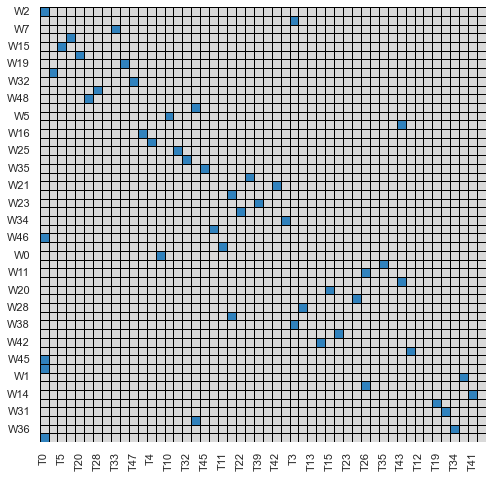

In [10]:
options1 = {"cmap":"tab20c","linecolor":"black","linewidth":1,"cbar":False}
x0 = simple_wta.greedy(prob)
A1 = np.ones((n_w,n_t))
for i in range(len(x0)):
    A1[W_idx[i],T_idx[x0[i]]] = 0
rows = ["W%d"%w for w in W]
columns = ["T%d"%t for t in T]
df1 = pd.DataFrame(A1,index=rows,columns=columns)
mat1 = sns.heatmap(df1,**options1)

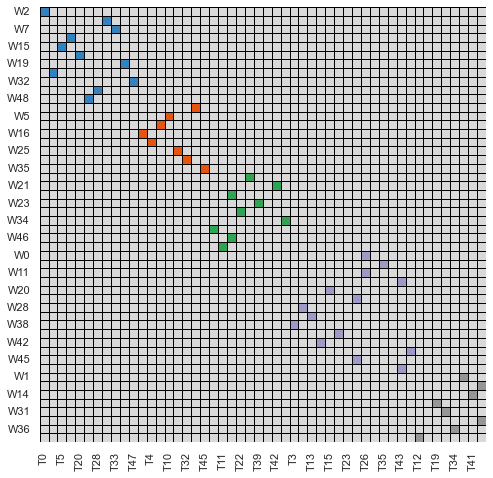

In [11]:

options2 = {"cmap":"tab20c","linecolor":"black","linewidth":1,"cbar":False}
colors = [10,30,50,70,90]
A2 = 100*np.ones((n_w,n_t))
for i in range(n_c):
    x = x_cluster[i]
    for j in range(len(x)):
        w = weapons[i][j]
        t = targets[i][x[j]]
        A2[W_idx[w],T_idx[t]] = colors[i]
rows = ["W%d"%w for w in W]
columns = ["T%d"%t for t in T]
df2 = pd.DataFrame(A2,index=rows,columns=columns)
mat2 = sns.heatmap(df2,**options2)

<AxesSubplot:>

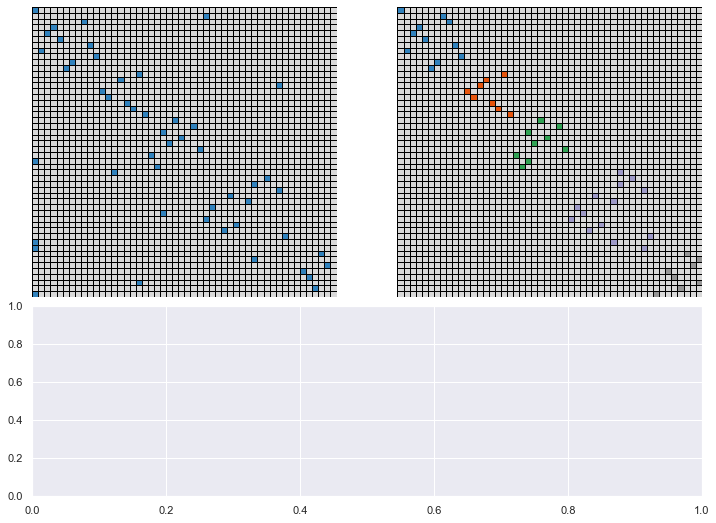

In [12]:
# prototyping the big figure
# fig, axs = plt.subplo

from matplotlib.gridspec import GridSpec
options1 = {"cmap":"tab20c","linecolor":"black","linewidth":1,"cbar":False,"xticklabels":False,"yticklabels":False}
options2 = {"cmap":"tab20c","linecolor":"black","linewidth":1,"cbar":False,"xticklabels": False,"yticklabels":False}
fig = plt.figure(figsize=(12,9))
gs = GridSpec(5,2,figure=fig,hspace=.1)
matax1 = fig.add_subplot(gs[0:3,0])
matax2 = fig.add_subplot(gs[0:3,1])
costax = fig.add_subplot(gs[3:,:])
sns.heatmap(df1,ax=matax1,**options1)
sns.heatmap(df2,ax=matax2,**options2)


In [13]:
# now to generate TONS of data

frames1 = []
frames2 = []
R1 = regret_matching.greedy_regret(prob)
R2 = [regret_matching.greedy_regret(p) for p in probs]
P1 = np.ones(prob.p.shape)/prob.p.shape[1]
P2 = [np.ones(p.p.shape)/p.p.shape[1] for p in probs]
k = 0
x1 = simple_wta.greedy(prob)
x2 = [simple_wta.greedy(p) for p in probs]


rng = np.random.RandomState(seed=1)
for i in range(1,200):
    regret_matching.iterate(prob,R1,P1,x1,i,rng=rng)
    frames1.append({"R":R1.copy(),"P":P1.copy(),"x":x1.copy()})
    for j in range(len(probs)):
        regret_matching.iterate(probs[j],R2[j],P2[j],x2[j],i,rng=rng)
    frames2.append({
        "R": [R.copy() for R in R2],
        "P": [P.copy() for P in P2],
        "x": [x.copy for x in x2]
    })

c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
MovieWriter ffmpeg unavailable; using Pillow instead.


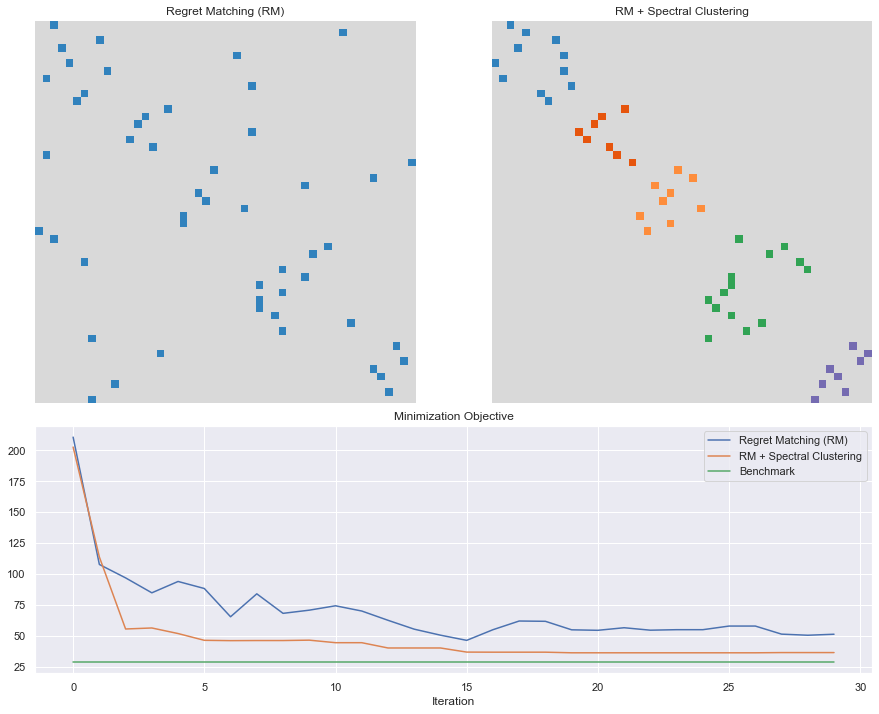

In [14]:
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FFMpegWriter 
from matplotlib.animation import FuncAnimation
options1 = {"cmap":"tab20c","linecolor":"black","linewidth":0,"cbar":False,"xticklabels":False,"yticklabels":False}
options2 = {"cmap":"tab20c","linecolor":"black","linewidth":0,"cbar":False,"xticklabels": False,"yticklabels":False}

x0 = simple_wta.greedy(prob)
A1 = np.ones((n_w,n_t))
rows = ["W%d"%w for w in W]
columns = ["T%d"%t for t in T]
df1 = pd.DataFrame(A1,index=rows,columns=columns)

colors = [10,30,35,50,65]
A2 = 100*np.ones((n_w,n_t))
rows = ["W%d"%w for w in W]
columns = ["T%d"%t for t in T]
df2 = pd.DataFrame(A2,index=rows,columns=columns)

fig = plt.figure(figsize=(15,12))
gs = GridSpec(5,2,figure=fig,hspace=.2)
matax1 = fig.add_subplot(gs[0:3,0])
matax1.set_title("Regret Matching (RM)")
matax2 = fig.add_subplot(gs[0:3,1])
matax2.set_title("RM + Spectral Clustering")
costax = fig.add_subplot(gs[3:,:])
costax.set_title("Minimization Objective")
costax.plot([],[])
costax.plot([],[])
costax.plot([],[])
c_ahuja = prob.objective(ahuja.optimize(prob))
lines = costax.lines


def update_figure(k):
    P = frames1[k]["P"]
    x = np.argmax(P,axis=1)
    c1 = prob.objective(x)
    for i in range(len(x)):
        old_j = np.argmin(A1[W_idx[i],:])
        A1[W_idx[i],old_j] = 1
        A1[W_idx[i],T_idx[x[i]]] = 0
    sns.heatmap(ax=matax1,data=df1,**options1)

    X = [np.argmax(P,axis=1) for P in frames2[k]["P"]]
    c2 = np.sum([probs[i].objective(X[i]) for i in range(len(X))])
    for j in range(len(X)):
        x = X[j]
        for i in range(len(x)):
            row = W_idx[weapons[j][i]]
            old_col = np.argmin(A2[row,:])
            A2[row,old_col] = 100
            t = targets[j][x[i]]
            new_col = T_idx[t]
            A2[row,new_col] = colors[j]
    sns.heatmap(df2,ax=matax2,**options2)

    xdata,ydata1 = lines[0].get_data()
    xdata = np.append(xdata,[k])
    ydata1 = np.append(ydata1,[c1])

    ydata2 = lines[1].get_ydata()
    ydata2 = np.append(ydata2,[c2])
    
    ydata3 = lines[2].get_ydata()
    ydata3 = np.append(ydata3, [c_ahuja])

    costax.clear()
    costax.plot(xdata,ydata1)
    costax.plot(xdata,ydata2)
    costax.plot(xdata,ydata3)
    costax.legend(["Regret Matching (RM)", "RM + Spectral Clustering", "Benchmark"],loc="upper right")
    plt.xlabel("Iteration")
    plt.title("Minimization Objective")
    return [fig]

ani = FuncAnimation(fig,update_figure,frames=30,blit=True)
ani.save("foobar.gif",fps=5)